In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.stats import norm
from sklearn.manifold import TSNE
import time, copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

!pip install captum
from captum.attr import Saliency
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

import sys ; sys.path.append('..')
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master
!git clone https://github.com/greydanus/mnist1d

sys.path.append('./mnist1d/mnist1d') ; sys.path.append('./mnist1d/notebooks')
import mnist1d

from data import get_templates, get_dataset_args, get_dataset
from train import get_model_args, train_model
from models import ConvBase, GRUBase, MLPBase, LinearBase
from utils import set_seed, plot_signals, ObjectView, from_pickle

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
#DEVICE = 'cpu'
print('Using:', DEVICE)

  Cloning https://github.com/greydanus/mnist1d.git (to revision master) to /tmp/pip-req-build-uo08mwst
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git /tmp/pip-req-build-uo08mwst
  Resolved https://github.com/greydanus/mnist1d.git to commit f31dff482e1aa77a5acfb6c964c5082a9e9d720d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
fatal: destination path 'mnist1d' already exists and is not an empty directory.
Using: cuda


In [2]:
torch.cuda.is_available()

True

### Generate Dataset

Did or could not load data from ./mnist1d_custom.pkl. Rebuilding dataset...


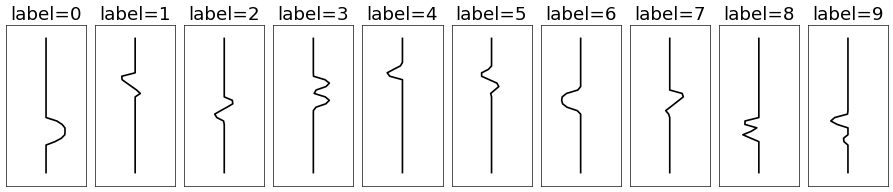

In [3]:
# Here's some plotting of the orignal dataset before any noise or
# transformations are added -- this is attributed to https://github.com/greydanus/mnist1d
templates = get_templates()
x = templates['x']
t = templates['t']
y = templates['y']

# Load base args
baseline_arg_dict = get_dataset_args(as_dict=True)

# These are some possible transformations we could have added, but again,
# just showing the orignal signals here
baseline_arg_dict['padding'] = [36, 60]
baseline_arg_dict['max_translation'] = 48
baseline_arg_dict['scale_coeff'] = 0
baseline_arg_dict['corr_noise_scale'] = 0
baseline_arg_dict['iid_noise_scale'] = 0
baseline_arg_dict['shear_scale'] = 0
baseline_args = ObjectView(baseline_arg_dict)

baseline_data = get_dataset(baseline_args, path='./mnist1d_custom.pkl', download=False, regenerate=True)
set_seed(baseline_args.seed)
fig = plot_signals(x, t, labels=y, args=baseline_args, ratio=2.2, do_transform=True)

Did or could not load data from ./mnist1d_custom.pkl. Rebuilding dataset...


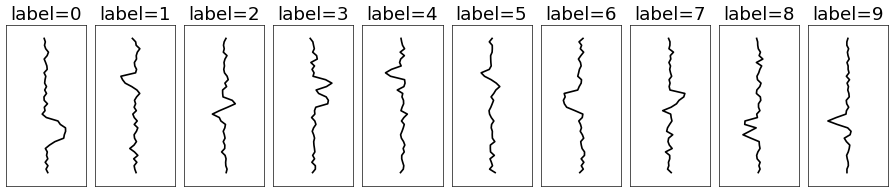

<Figure size 640x480 with 0 Axes>

In [4]:
# Now I make the same plots but with some small amount of noise
# added into the data. This forms the baseline dataset for my experiments
templates = get_templates()
x = templates['x']
t = templates['t']
y = templates['y']

# Load base args
arg_dict = get_dataset_args(as_dict=True)

# And Now I just add a bit of noise! That's the only
# transformation I do for now -- keeping it simple
arg_dict['padding'] = [36, 60]
arg_dict['max_translation'] = 48
arg_dict['scale_coeff'] = 0
arg_dict['corr_noise_scale'] = 0
arg_dict['iid_noise_scale'] = 0.05 # Here's where that's done
arg_dict['shear_scale'] = 0
args = ObjectView(arg_dict)

data = get_dataset(args, path='./mnist1d_custom.pkl', download=False, regenerate=True)
set_seed(args.seed)
fig = plot_signals(x, t, labels=y, args=args, ratio=2.2, do_transform=True)
plt.savefig('mnist', dpi = 200)

In [6]:
# Now to that baseline dataset I'd like to add some spurious correlations
# This function
# takes a dataset X,y and adds what I call 'gaussian artifacts' to a given percent of the samples:

def gaussian_artifact(X,y, percent):
    rands = np.zeros(X.shape)
    cols = X.shape[1]
    idxs = range(cols)
    labs = np.unique(y)

    # samples chosen randomly
    rand_idxs = np.random.choice(range(len(y)), int(len(y)*percent), replace = False)

    for l in range(len(labs)):
        # IMPORTANT: I'm using a specific random state here for testing purposes
        np.random.seed(42)

        # generate random noise
        rand_noise = np.abs(np.random.normal(2,1))
        for i in rand_idxs:
            if y[i] == l:

                # And add that noise to a small set of features
                rands[i,max(int((cols/len(labs))*y[i])-3, 0):int((cols/len(labs))*y[i])+2] += rand_noise

    return X + rands

In [7]:
# Make the spurious dataset!
X = data['x']
y = data['y']
# give spurious features to 90% of the data
X_transform = gaussian_artifact(X,y, 0.9)
data_transform = {'x': X_transform, 'x_test': data['x_test'], 'y':y, 'y_test':data['y_test']}

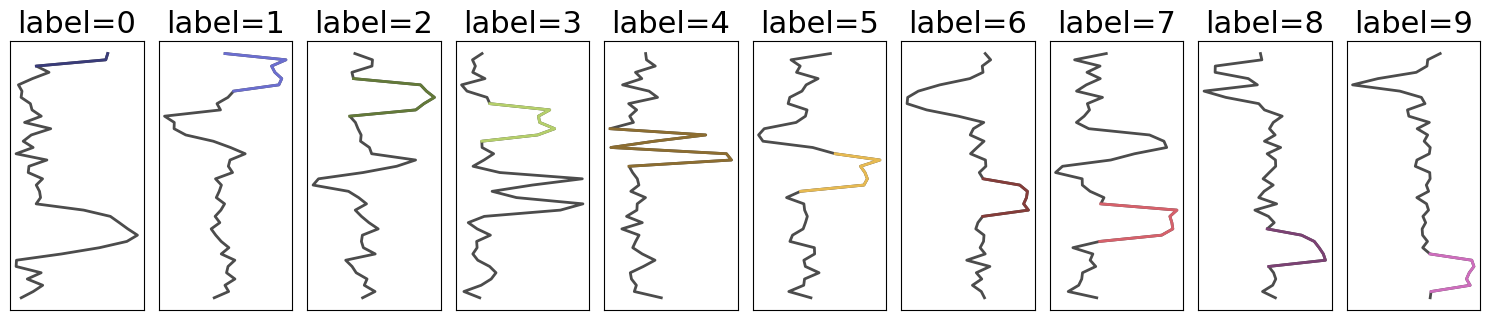

In [8]:
# And now I do some plotting of the new spurious dataset
cols = X.shape[1]
idxs = range(cols)
labs = np.unique(y)

fig_rows, fig_cols = 1, 10
ratio = 2.2
zoom = 0.5
fig = plt.figure(figsize=[fig_cols*1.5,fig_rows*1.5*ratio], dpi=100)
tdat = data['templates']['t']
t = np.linspace(np.min(tdat),np.max(tdat),40)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i/len(labs)) for i in range(len(labs))]
shift_back = 4
shift_forward = 3

for l in range(len(labs)):
  xi =  X_transform[np.where(y == labs[l])[0][1]]
  ax = plt.subplot(fig_rows,fig_cols,l+1)
  #plt.plot(xi[:center-shift_back],t[:center-shift_back], 'k-', linewidth=2)
  #plt.plot(xi[center + shift_forward:],t[center + shift_forward:], 'k-', linewidth=2)
  plt.plot(xi,t, 'k-', linewidth=2, alpha = 0.7)

  center = int((cols/len(labs))*l)
  if center > 0:
      plt.plot(xi[center - shift_back: center + shift_forward],t[center - shift_back: center + shift_forward], c=colors[l], linewidth=2, alpha = 1)
  else:
      plt.plot(xi[center:center + shift_forward],t[center:center + shift_forward], c=colors[l], linewidth=2)

  plt.title("label=" + str(l), fontsize=22)

  plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('mnist_spurious', dpi = 200)
plt.show()

### T-SNE visualization

In [9]:
# Embedding with T-SNE!
# First with the baseline dataset
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

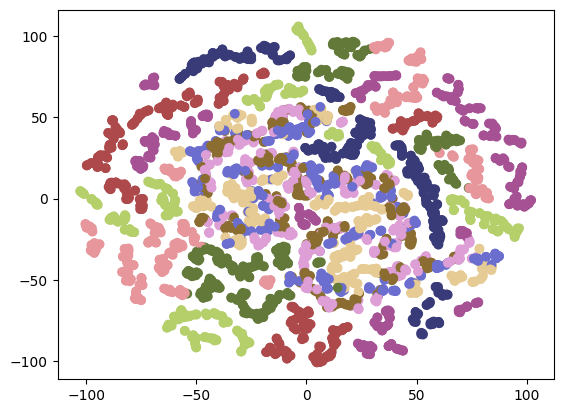

In [10]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = y, cmap = 'tab20b')
plt.savefig('tsne', dpi = 200)

In [11]:
# And then with the transformed, spurious dataset
X_embedded_transform = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_transform)

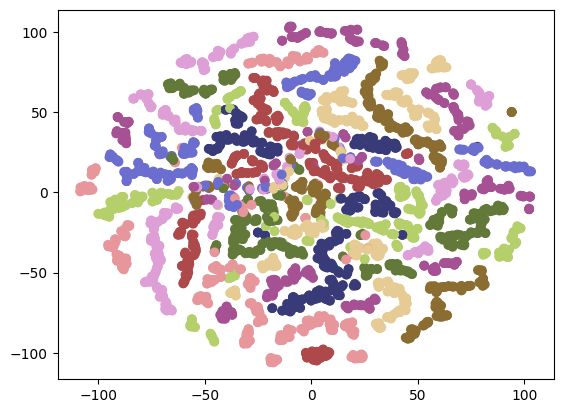

In [12]:
plt.scatter(X_embedded_transform[:,0], X_embedded_transform[:,1], c = y, cmap = 'tab20b')
plt.savefig('tsne_spurious', dpi = 200)

### Run models

In [16]:
# Reweighted loss function to account for under-represented training samples
class ReWeighted_CE_Loss(nn.Module):
    def __init__(self, model, initial_params, reg_strength=0):
        super(ReWeighted_CE_Loss, self).__init__()
        self.model = model
        self.initial_params = initial_params
        self.reg_strength = reg_strength
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    # takes a target label and an array of weights to apply to the samples
    def forward(self, output, target, sample_weights):
        # Cross entropy loss with sample-specific weights
        ce_loss = self.criterion(output, target)
        weighted_ce_loss = ce_loss * sample_weights
        weighted_ce_loss = weighted_ce_loss.mean()

        # Regularization term: L2 distance between current and initial parameters
        current_params = torch.cat([p.view(-1) for p in self.model.linear.parameters()])
        reg_loss = self.reg_strength * torch.norm(current_params - self.initial_params)

        # Total loss
        total_loss = weighted_ce_loss + reg_loss
        return total_loss

In [17]:
# Accuracy and worst group accuracy scores to measure test performance
def accuracy(model, inputs, targets):
  preds = model(inputs).argmax(-1).cpu().numpy()
  targets = targets.cpu().numpy().astype(np.float32)
  return 100*sum(preds==targets)/len(targets)


def worst_group_accuracy(model, inputs, targets):
    preds = model(inputs).argmax(dim=-1).cpu().numpy()
    targets = targets.cpu().numpy().astype(np.float32)

    # Find unique labels to calculate accuracy for each group
    unique_labels = np.unique(targets)
    accuracies = []

    # Calculate accuracy for each unique label
    for label in unique_labels:
        label_mask = (targets == label)
        label_correct = (preds[label_mask] == targets[label_mask]).sum()
        label_total = label_mask.sum()
        label_accuracy = 100.0 * label_correct / label_total if label_total > 0 else 0
        accuracies.append(label_accuracy)

    # Determine the worst group accuracy
    worst_accuracy = min(accuracies) if accuracies else 0
    return worst_accuracy

In [18]:
# Ok.. I have a few functions to train different models at different stages


# 1) This is the base training function
# It comes from: https://github.com/greydanus/mnist1d

def train_model(dataset, model, args):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), args.learning_rate, weight_decay=args.weight_decay)

  x_train, x_test = torch.Tensor(dataset['x']), torch.Tensor(dataset['x_test'])
  y_train, y_test = torch.LongTensor(dataset['y']), torch.LongTensor(dataset['y_test'])

  model = model.to(args.device)
  x_train, x_test, y_train, y_test = [v.to(args.device) for v in [x_train, x_test, y_train, y_test]]

  results = {'checkpoints':[], 'train_losses':[], 'test_losses':[],'train_acc':[],'test_acc':[],
             'train_wacc':[], 'test_wacc':[]}
  t0 = time.time()
  for step in range(args.total_steps+1):
      bix = (step*args.batch_size)%len(x_train) # batch index
      x, y = x_train[bix:bix+args.batch_size], y_train[bix:bix+args.batch_size]

      loss = criterion(model(x), y)
      results['train_losses'].append(loss.item())
      loss.backward() ; optimizer.step() ; optimizer.zero_grad()

      if args.eval_every > 0 and step % args.eval_every == 0: # evaluate the model
          test_loss = criterion(model(x_test), y_test)
          results['test_losses'].append(test_loss.item())
          results['train_acc'].append(accuracy(model, x_train, y_train))
          results['test_acc'].append(accuracy(model, x_test, y_test))

          # Report worst group accuracies!
          results['train_wacc'].append(worst_group_accuracy(model, x_train, y_train))
          results['test_wacc'].append(worst_group_accuracy(model, x_test, y_test))

      if step > 0 and step % args.print_every == 0: # print out training progress
          t1 = time.time()
          print("step {}, dt {:.2f}s, train_loss {:.3e}, test_loss {:.3e}, train_acc {:.1f}, test_acc {:.1f}"
              .format(step, t1-t0, loss.item(), results['test_losses'][-1], \
                      results['train_acc'][-1], results['test_acc'][-1]))
          t0 = t1

      if args.checkpoint_every > 0 and step % args.checkpoint_every == 0: # save model checkpoints
          model.step = step
          results['checkpoints'].append( copy.deepcopy(model) )
  return results



# 2) Now I change it slightly so that I can focus on only training parameters in the final
# linear layer

def stage1_train(dataset, model, args):
  criterion = nn.CrossEntropyLoss()

  # This change allows me to freeze some parameters and reweight the last layer!
  # This is really the only important change
  optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    args.learning_rate,
    weight_decay=args.weight_decay)

  x_train, x_test = torch.Tensor(dataset['x']), torch.Tensor(dataset['x_test'])
  y_train, y_test = torch.LongTensor(dataset['y']), torch.LongTensor(dataset['y_test'])

  model = model.to(args.device)
  x_train, x_test, y_train, y_test = [v.to(args.device) for v in [x_train, x_test, y_train, y_test]]

  results = {'checkpoints':[], 'train_losses':[], 'test_losses':[],'train_acc':[],'test_acc':[],
             'train_wacc':[], 'test_wacc':[]}
  t0 = time.time()
  for step in range(args.total_steps+1):
      bix = (step*args.batch_size)%len(x_train) # batch index
      x, y = x_train[bix:bix+args.batch_size], y_train[bix:bix+args.batch_size]

      loss = criterion(model(x), y)
      results['train_losses'].append(loss.item())
      loss.backward() ; optimizer.step() ; optimizer.zero_grad()

      if args.eval_every > 0 and step % args.eval_every == 0: # evaluate the model
          test_loss = criterion(model(x_test), y_test)
          results['test_losses'].append(test_loss.item())
          results['train_acc'].append(accuracy(model, x_train, y_train))
          results['test_acc'].append(accuracy(model, x_test, y_test))

          results['train_wacc'].append(worst_group_accuracy(model, x_train, y_train))
          results['test_wacc'].append(worst_group_accuracy(model, x_test, y_test))

      if step > 0 and step % args.print_every == 0: # print out training progress
          t1 = time.time()
          print("step {}, dt {:.2f}s, train_loss {:.3e}, test_loss {:.3e}, train_acc {:.1f}, test_acc {:.1f}"
              .format(step, t1-t0, loss.item(), results['test_losses'][-1], \
                      results['train_acc'][-1], results['test_acc'][-1]))
          t0 = t1

      if args.checkpoint_every > 0 and step % args.checkpoint_every == 0: # save model checkpoints
          model.step = step
          results['checkpoints'].append( copy.deepcopy(model) )
  return results


# 3) And this training function uses the re-weighted loss function
# and also only focuses on parameters from the last linear layer.
# In addition to the previously required parameters I now also now take the training sample weights as input
def stage2_train(dataset, model, args, sample_weights):
  initial_params = torch.cat([p.view(-1) for p in model.linear.parameters()])

  # Here's where I update the model criterion!
  criterion = ReWeighted_CE_Loss(model, initial_params)
  test_criterion = nn.CrossEntropyLoss()

  # This change allows me to freeze some parameters and reweight the last layer!
  optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    args.learning_rate,
    weight_decay=args.weight_decay)

  x_train, x_test = torch.Tensor(dataset['x']), torch.Tensor(dataset['x_test'])
  y_train, y_test = torch.LongTensor(dataset['y']), torch.LongTensor(dataset['y_test'])

  model = model.to(args.device)
  x_train, x_test, y_train, y_test = [v.to(args.device) for v in [x_train, x_test, y_train, y_test]]

  results = {'checkpoints':[], 'train_losses':[], 'test_losses':[],'train_acc':[],'test_acc':[],
             'train_wacc':[], 'test_wacc':[]}
  t0 = time.time()
  for step in range(args.total_steps+1):
      bix = (step*args.batch_size)%len(x_train) # batch index
      x, y = x_train[bix:bix+args.batch_size], y_train[bix:bix+args.batch_size]

      # Create uniform weights, could be replaced with dynamic or specific weights if needed
      batch_sample_weights = sample_weights[bix:bix+args.batch_size]

      loss = criterion(model(x), y, batch_sample_weights)
      results['train_losses'].append(loss.item())
      loss.backward() ; optimizer.step() ; optimizer.zero_grad()

      if args.eval_every > 0 and step % args.eval_every == 0: # evaluate the model
          test_loss = test_criterion(model(x_test), y_test)
          results['test_losses'].append(test_loss.item())
          results['train_acc'].append(accuracy(model, x_train, y_train))
          results['test_acc'].append(accuracy(model, x_test, y_test))
          results['train_wacc'].append(worst_group_accuracy(model, x_train, y_train))
          results['test_wacc'].append(worst_group_accuracy(model, x_test, y_test))

      if step > 0 and step % args.print_every == 0: # print out training progress
          t1 = time.time()
          print("step {}, dt {:.2f}s, train_loss {:.3e}, test_loss {:.3e}, train_acc {:.1f}, test_acc {:.1f}"
              .format(step, t1-t0, loss.item(), results['test_losses'][-1], \
                      results['train_acc'][-1], results['test_acc'][-1]))
          t0 = t1

      if args.checkpoint_every > 0 and step % args.checkpoint_every == 0: # save model checkpoints
          model.step = step
          results['checkpoints'].append( copy.deepcopy(model) )
  return results

In [19]:
# Take a small portion (25%) of the original, untransformed dataset
# We'll use this for re-training the last layer of the model
percent = 0.25
idxs = np.random.choice(range(data['x'].shape[0]), int(percent*data['x'].shape[0]), replace = False)
x_sub = data['x'][idxs,:]
y_sub = data['y'][idxs]
data_sub = {'x':x_sub, 'y':y_sub, 'x_test':data['x_test'], 'y_test':data['y_test']}

In [20]:
# Ok and now here's where I train all of the models:
args = get_model_args()
args.total_steps = 6000
args.device = DEVICE

set_seed(args.seed)

# train a convolutional neural network on the original dataset
conv_model = ConvBase(output_size=args.output_size)
results_cnn = train_model(data, conv_model, args)

# train the same model but with data having spurious correlations
conv_spurious = ConvBase(output_size=args.output_size)
results_spurious = stage1_train(data_transform, conv_spurious, args)


# Now we can either re-train the last layer with some new data:
spurious_retrain = copy.deepcopy(conv_spurious)

# Freeze all convolutional layer parameters
for param in spurious_retrain.parameters():
    param.requires_grad = False

# Specifically re-enable training for the last linear layer
for param in spurious_retrain.linear.parameters():
    param.requires_grad = True

results_retrain = stage1_train(data_sub, spurious_retrain, args)


# And now we could also do re-weighting on the original training data
outputs = conv_spurious(torch.Tensor(data_transform['x']).to(DEVICE))
probabilities = F.softmax(outputs, dim=1).cpu().detach().numpy()
num_labels = len(np.unique(data_transform['y']))

# define weights here:
Beta = np.zeros(num_labels)
sample_weights = np.zeros(len(outputs))
gamma = 0.1

for i in range(num_labels):
  label_idxs = np.where(data_transform['y'] == i)[0]
  Beta[i] = len(label_idxs)

for i in range(num_labels):
  for j in label_idxs:
    pred_prob = probabilities[j,i]
    sample_weights[j] = Beta[i]*np.exp(-gamma*pred_prob)

sample_weights /= np.sum(sample_weights)


spurious_reweight = copy.deepcopy(conv_spurious)
results_reweight = stage2_train(data_transform, spurious_reweight, args, torch.tensor(sample_weights).to(DEVICE))

Initialized ConvBase model with 5210 parameters
step 1000, dt 3.16s, train_loss 6.315e-02, test_loss 1.125e-01, train_acc 99.3, test_acc 95.9
step 2000, dt 2.90s, train_loss 1.173e-02, test_loss 2.135e-01, train_acc 99.4, test_acc 95.6
step 3000, dt 1.85s, train_loss 3.708e-04, test_loss 1.652e-01, train_acc 100.0, test_acc 96.7
step 4000, dt 2.17s, train_loss 1.512e-04, test_loss 1.793e-01, train_acc 100.0, test_acc 96.9
step 5000, dt 1.80s, train_loss 7.503e-05, test_loss 1.909e-01, train_acc 100.0, test_acc 96.8
step 6000, dt 1.79s, train_loss 3.890e-05, test_loss 2.020e-01, train_acc 100.0, test_acc 96.8
Initialized ConvBase model with 5210 parameters
step 1000, dt 2.96s, train_loss 2.514e-02, test_loss 2.702e+00, train_acc 99.0, test_acc 48.7
step 2000, dt 2.68s, train_loss 2.084e-05, test_loss 3.477e+00, train_acc 100.0, test_acc 55.4
step 3000, dt 2.74s, train_loss 5.437e-06, test_loss 3.772e+00, train_acc 100.0, test_acc 56.2
step 4000, dt 3.38s, train_loss 2.326e-06, test_loss

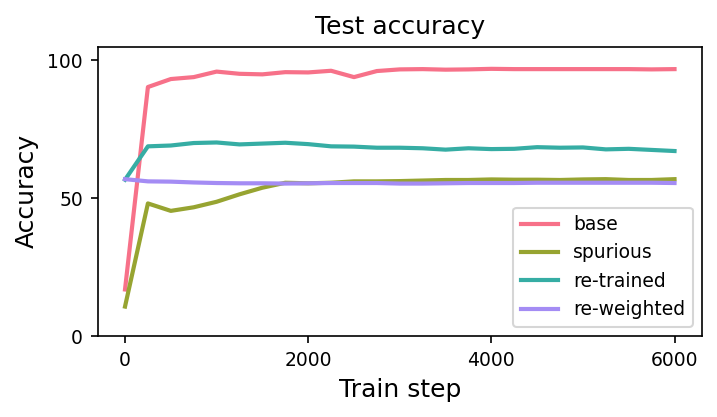

In [21]:
# And Plot the results!
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.rcParams.update({'font.size': 14})
pal = sns.color_palette("husl", 8)
plt.subplot(1,1,1)
t = range(0, args.total_steps+1, args.eval_every)

# change 'test_acc' to 'test_wacc' to see worst group accuracies!
plt.plot(t, results_cnn['test_acc'], c=pal[0], label='base', linewidth = 2)
plt.plot(t, results_spurious['test_acc'], c=pal[2], label='spurious', linewidth = 2)
plt.plot(t, results_retrain['test_acc'], c=pal[4], label='re-trained', linewidth = 2)
plt.plot(t, results_reweight['test_acc'], c=pal[6], label='re-weighted', linewidth = 2)

plt.title('Test accuracy', fontsize = 12) ; plt.xlabel("Train step", fontsize = 12) ;
plt.legend(fontsize=9, loc='lower right')
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9)
plt.ylim(0,105)
plt.tight_layout()
plt.savefig('mnist_accuracy', dpi = 200)
plt.show()

### Saliency

In [22]:
# Finally I did some saliency analysis
# Choose a model from one of the previously trained models:
model = conv_model
model.eval()
# Choose a target label to see which features the spurious model focuses on!
target_label = 7
Xtest = torch.tensor(data_transform['x']).float().to(DEVICE)
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
ig_nt_attr_test = ig_nt.attribute(Xtest, target = target_label)
ig_nt_attr_test_sum = ig_nt_attr_test.cpu().detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

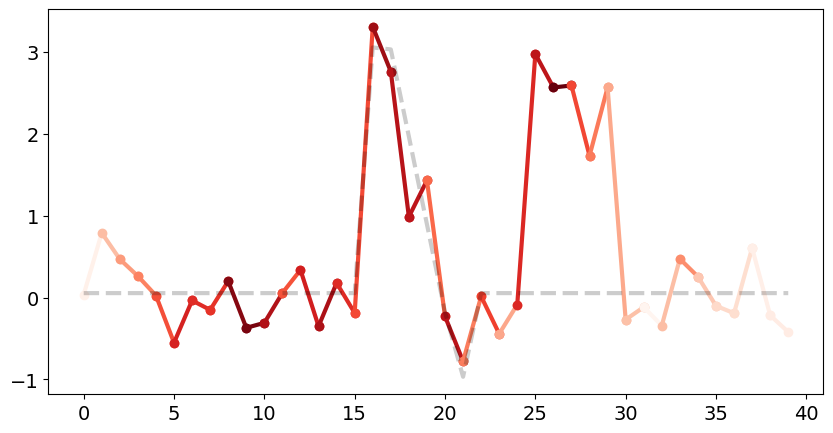

In [23]:
# Example data
targetidx = np.where(data_transform['y'] == target_label)[0][0]
values = data_transform['x'][targetidx,:] # The y-values of points
color_values = np.abs(ig_nt_attr_test_norm_sum)  # Numerical values to map to colors

# Normalize color values to fit 0-1 range
norm = Normalize(vmin=min(color_values), vmax=max(color_values))
cmap = cm.Reds

# Setting up the plot
plt.figure(figsize=(10, 5))

# Plot each segment with the specified color
for i in range(len(values) - 1):
    plt.plot([i, i+1], [values[i], values[i+1]], color=cmap(norm(color_values[i])), linewidth = 3, marker = 'o')


baseidx = np.where(baseline_data['y'] == target_label)[0][0]
base_values = baseline_data['x'][baseidx,:]
plt.plot(base_values, c='k', alpha = 0.2, linewidth = 3, linestyle = '--')
plt.savefig('saliency_7', dpi = 200)
plt.show()